In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('ggplot')

import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeat
import cartopy.io.img_tiles as cimgt

import AISMapPlot as aismap

In [118]:
ais_learners = []
sectors = [0, 1, 2, 3, 4, 5]
sector_borders = [52.8, 4.8, 6.0, 7.2, 8.6, 9.81]
positions = pd.DataFrame([[52.8, np.nan], [np.nan, 4.8], [np.nan, 6.0], [np.nan, 7.2], [np.nan, 8.6], [np.nan, 9.81]],
                         columns = ['Latitude', 'Longitude'])
for s in sectors:
    ais_learners.append(pd.read_pickle('ROT-HAM_learners_60min_s%d.pkl' % (s)))

In [119]:
positions

,Latitude,Longitude
0,52.8,NaN
1,NaN,4.80
2,NaN,6.00
3,NaN,7.20
4,NaN,8.60
5,NaN,9.81


In [14]:
ais_learners[0].head()

,TripID,time,Length,Breadth,Draught,Latitude,Longitude,SOG,COG,TH,...,hour_of_day,weekday,day_of_month,month,sector,mins_to_sector_leave,sector_leave_lat,sector_leave_lon,sector_leave_sog,sector_leave_cog
0,1000226,2016-06-15 14:00:00,369.0,51.0,13.8,51.970000,4.033333,5.200000,112.633333,112.000000,...,14.0,2.0,15.0,6.0,0,300.000000,52.8,4.2,12.8,34.3
1,1000226,2016-06-15 15:00:00,369.0,51.0,13.8,51.973830,4.046596,9.325532,196.780851,196.914894,...,15.0,2.0,15.0,6.0,0,274.595745,52.8,4.2,12.8,34.3
2,1000226,2016-06-15 16:00:00,369.0,51.0,13.8,52.134250,3.888500,12.945000,256.532500,345.275000,...,16.0,2.0,15.0,6.0,0,202.650000,52.8,4.2,12.8,34.3
3,1000226,2016-06-15 17:00:00,369.0,51.0,13.8,52.328793,3.868621,13.075862,153.406897,152.448276,...,17.0,2.0,15.0,6.0,0,149.017241,52.8,4.2,12.8,34.3
4,1000226,2016-06-15 18:00:00,369.0,51.0,13.8,52.530930,3.936512,12.574419,24.613953,23.418605,...,18.0,2.0,15.0,6.0,0,90.046512,52.8,4.2,12.8,34.3


In [18]:
X = []
y = []
for s in sectors:
    X.append(ais_learners[s][['Latitude', 'Longitude']])
    y.append(ais_learners[s][['sector_leave_lat', 'sector_leave_lon']])

In [72]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score

cv_splits = []
for s in sectors:
    cv_splits.append(list(GroupKFold(n_splits = 10).split(X[s], y[s], groups = ais_learners[s]['TripID'])))

In [73]:
# Retrieve ONE simple train-test split (for each sector)
train_indices = []
test_indices = []
for s in sectors:
    a, b = cv_splits[s][0]
    train_indices.append(a)
    test_indices.append(b)

X_train = []
X_test = []
for s in sectors:
    X_train.append(X[s].iloc[train_indices[s]])
    X_test.append(X[s].iloc[test_indices[s]])

y_train = []
y_test = []
for s in sectors:
    y_train.append(y[s].iloc[train_indices[s]])
    y_test.append(y[s].iloc[test_indices[s]])

In [142]:
from sklearn.neighbors import KNeighborsRegressor

for s in sectors:
    knn = LinearRegression()
    scores = cross_val_score(lin, X[s], y[s], cv = cv_splits[s], scoring = 'neg_mean_absolute_error')
    print(scores.mean())

-0.027936073866
-0.0625291246014
-0.0604321599653
-0.0621845699807
-0.0660336235813
-0.024646963837


In [137]:
knn_list = []
for s in sectors:
    knn = KNeighborsRegressor(n_neighbors = 20)
    if s == 0:
        knn.fit(X_train[s], y_train[s]['sector_leave_lon'])
    else:
        knn.fit(X_train[s], y_train[s]['sector_leave_lat'])
    knn_list.append(knn)

In [138]:
knn_list[4].predict([[53.99, 8.17]])

array([ 53.9505])

In [139]:
# 51.99 4.07
lats = [51.99]
lons = [4.07]
for s in sectors:
    if s == 0:
        print(sector_borders[0])
        lat = sector_borders[0]
        lon = knn_list[0].predict([pred_pos[-1]])[0]
    else:
        lat = knn_list[s].predict([pred_pos[-1]])[0]
        lon = sector_borders[s]
    lats.append(lat)
    lons.append(lon)
print(lats)
print(lons)

52.8
[51.99, 52.8, 53.603164062177214, 53.781447257820048, 53.907666987025792, 53.739298399687797, 53.550500000000035]
[4.07, 4.2888290755752072, 4.8, 6.0, 7.2, 8.6, 9.81]


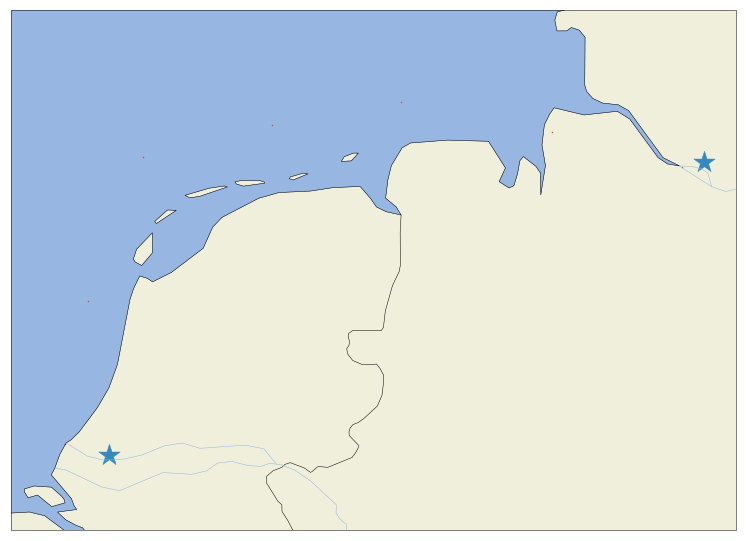

In [140]:
aismap.plot_to_map(size = (13, 13), longitude = pd.Series(lons), latitude = pd.Series(lats))